In [1]:
import numpy as np
import pandas as pd
from river import optim
from river.drift import ADWIN
from ray.tune.sklearn import TuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml import PipeLineSelection
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.transfomers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps)

[2023-06-26 16:53:01:117] - INFO - SAIL : created SAILPipeline object with ID 868afe4b-c853-4de6-bcea-1712519bcc46


#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance


In [6]:
pipeline_selection = PipeLineSelection(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    scoring="Accuracy",
    search_data_size=1000,
    search_method=TuneGridSearchCV,
    search_method_params={
        "max_iters": 1,
        "early_stopping": False,
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
    },
    drift_detector=ADWIN(delta=0.001),
)

#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

start = 0
for end in range(50, 2001, batch_size):

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = pipeline_selection.predict(X_train)
        y_preds.extend(list(preds))
        y_true.extend(list(y_train))

    pipeline_selection.partial_fit(X_train, y_train, classifier__classes=[1, 0])
    start = end

2023-06-26 16:53:04,624	WARNING searcher.py:377 -- save not implemented for Searcher. Skipping save.
(_Trainable pid=23312) [2023-06-26 16:53:06:589] - INFO - SAIL : created SAILPipeline object with ID c7d85073-d572-482c-969b-c6e308ded3a2
(_Trainable pid=23312) [2023-06-26 16:53:06:589] - INFO - SAIL : created SAILPipeline object with ID 2ae06250-7844-41e8-89a8-875e320acf40
(_Trainable pid=23312) [2023-06-26 16:53:06:590] - INFO - SAIL : created SAILPipeline object with ID 827ee844-07cb-4a1f-bb3e-e1d41b59ce59
(_Trainable pid=23312) [2023-06-26 16:53:06:590] - INFO - SAIL : created SAILPipeline object with ID 0eb13807-9f9a-4394-a375-5b277d3309be
(_Trainable pid=23312) [2023-06-26 16:53:06:590] - INFO - SAIL : created SAILPipeline object with ID c060c40d-c8a0-4e81-be68-b855922efb07
(_Trainable pid=23312) [2023-06-26 16:53:06:604] - INFO - SAIL : created SAILPipeline object with ID a05b31a2-9047-4a2d-a477-f7898bf05828
(_Trainable pid=23312) [2023-06-26 16:53:06:629] - INFO - SAIL : create

(_Trainable pid=23312) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_Trainable pid=23312) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_Trainable pid=23312) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


2023-06-26 16:53:08,239	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
2023-06-26 16:53:09,708	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
[2023-06-26 16:53:09:744] - INFO - SAIL : created SAILPipeline object with ID 21c0987e-5550-47e4-ab84-681c50c37231
[2023-06-26 16:53:09:746] - INFO - SAIL : created SAILPipeline object with ID 0b527f09-27ed-446b-96d0-6f173ca83c39
[2023-06-26 16:53:10:100] - INFO - SAIL : Cumulative Pipeline Score: 0.84
[2023-06-26 16:53:10:100] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:128] - INFO - SAIL : Cumulative Pipeline Score: 0.89
[2023-06-26 16:53:10:129] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:156] - INFO - SAIL : Cumulative Pipeline Score: 0.88
[2023-06-26 16:53:10:156] - INFO - SAI

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.3s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-26 16:53:10:324] - INFO - SAIL : Cumulative Pipeline Score: 0.8888888888888888
[2023-06-26 16:53:10:324] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:352] - INFO - SAIL : Cumulative Pipeline Score: 0.886
[2023-06-26 16:53:10:352] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:379] - INFO - SAIL : Cumulative Pipeline Score: 0.8927272727272727
[2023-06-26 16:53:10:379] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:407] - INFO - SAIL : Cumulative Pipeline Score: 0.8933333333333333
[2023-06-26 16:53:10:407] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:436] - INFO - SAIL : Cumulative Pipeline Score: 0.8876923076923077
[2023-06-26 16:53:10:436] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:465] - INFO - SAIL : Cumulative Pipeline Score: 0.89
[2023-06-26 16:53:10:466] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 1

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-26 16:53:10:523] - INFO - SAIL : Cumulative Pipeline Score: 0.89125
[2023-06-26 16:53:10:524] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:558] - INFO - SAIL : Cumulative Pipeline Score: 0.8941176470588236
[2023-06-26 16:53:10:559] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:589] - INFO - SAIL : Cumulative Pipeline Score: 0.8955555555555555
[2023-06-26 16:53:10:589] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:619] - INFO - SAIL : Cumulative Pipeline Score: 0.8957894736842106
[2023-06-26 16:53:10:619] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-26 16:53:10:647] - INFO - SAIL : Cumulative Pipeline Score: 0.899
[2023-06-26 16:53:10:647] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


#### Classification Report

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       652
           1       0.92      0.78      0.84       348

    accuracy                           0.90      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.90      0.90      0.90      1000



#### Plot confusion matrix

<Axes: >

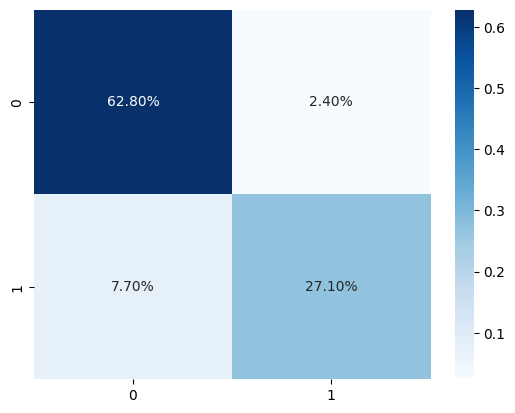

In [9]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')